# How does digest2 improve over LSST?

In this notebook we explain how digest2 improves over the course of LSST as objects are identified.

You can find code for creating Figure 7.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
import pandas as pd

import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

%config InlineBackend.figure_format = "retina"

from datetime import date

import numpy as np
from os import listdir

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import sys
sys.path.append("../current_criteria")
import helpers

import difi

In [4]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [5]:
s3m = pd.read_hdf("../../hybrid-sso-catalogs/catalogues/s3m_initial.h5")
hex_ids = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m.index.values))])
s3m_to_hex7 = dict(zip(s3m.index.values, hex_ids))

In [6]:
hex7_to_s3m = dict(zip(hex_ids, s3m.index.values))

In [7]:
s3m_to_hex7_bytes = dict(zip(s3m.index.values.astype("|S32"), hex_ids))

In [8]:
f2n = np.load("../current_criteria/rrent_criteria/f2n.npy", allow_pickle=True)

In [9]:
allf2n = np.concatenate(f2n)

# Work out the times

In [33]:
years = []
for i in range(0, 10):
    nights = []
    base = i * 365
    j = 0
    added = 0
    while j < 150 and added < 75:
        if base + j in allf2n:
            nights.append(base + j)
            added += 1
        j += 1
    years.append(nights)
years = np.asarray(years)

# Load in the IDs and night when they are found

In [18]:
mba_obs_ids = np.load("all_difi_MBA_ids.npy")

In [19]:
%%time
mba_hex_ids = np.array([s3m_to_hex7_bytes[mba_obs_ids[i]] for i in range(len(mba_obs_ids))])

CPU times: user 5.61 s, sys: 731 ms, total: 6.34 s
Wall time: 6.37 s


In [20]:
mba_nights_found = np.load("all_difi_MBA_nfs.npy")

In [14]:
neo_difi = pd.read_hdf("difi_NEOs_10yrs.h5", key="findable_observations")
neo_difi["hex_id"] = np.array([s3m_to_hex7[neo_difi["ObjID"].iloc[i]] for i in range(len(neo_difi))])

In [16]:
trailed_neos = pd.read_hdf("../mitigation_algorithm/neo_streakers.h5")

In [37]:
%%time
neo_traffics = np.zeros((10, 75))
for i in range(len(years)):
    for j in range(len(years[i])):
        scores, ids = helpers.get_neo_scores("../current_criteria/neo/", night=years[i][j])

        index = np.argsort(neo_difi["hex_id"].values)
        sorted_x = neo_difi["hex_id"].values[index]
        sorted_index = np.searchsorted(sorted_x, ids)

        yindex = np.take(index, sorted_index, mode="clip")
        
        found_ever = (neo_difi["hex_id"][yindex] == ids)
        not_yet_found = (found_ever & (neo_difi["night_found"][yindex] >= years[i][j]) | (~found_ever))
        trailed = np.isin(neo_difi["hex_id"][yindex], trailed_neos[trailed_neos["night"] == years[i][j]].index.values)
        
        print(years[i][j], (scores[not_yet_found & ~trailed] >= 65).sum())
        neo_traffics[i, j] = ((scores[not_yet_found & ~trailed] >= 65).sum())

0 37
1 75
2 58
3 153
4 135
5 120
6 149
7 77
8 249
9 36
10 134
11 211
12 190
13 87
14 49
15 100
16 64
17 55
18 129
20 95
21 46
22 113
23 93
24 14
25 38
26 32
28 34
29 23
30 44
31 75
32 114
33 133
41 68
42 77
43 173
44 137
45 162
46 186
47 129
48 106
49 66
50 142
51 118
52 25
53 22
54 37
55 41
56 21
57 26
58 21
59 19
60 77
61 77
62 112
63 40
64 51
65 129
66 130
67 28
68 70
69 126
70 28
71 111
72 178
73 112
74 100
75 172
76 63
77 106
78 143
79 56
80 147
81 84
82 41
83 7
365 30
368 140
369 222
370 91
371 23
372 83
374 64
375 42
376 10
379 15
380 18
381 26
383 44
384 27
385 69
386 117
387 33
388 149
389 199
390 68
391 78
392 60
393 99
394 121
395 21
396 100
398 62
407 42
408 16
409 22
410 29
411 33
412 7
414 68
415 58
416 104
417 213
418 352
420 194
421 122
422 112
423 194
424 95
425 155
426 252
427 140
428 64
429 152
430 174
431 206
432 125
433 6
434 38
437 46
438 50
439 86
440 62
441 38
442 70
443 110
444 159
447 258
448 292
449 230
450 231
451 137
452 115
453 165
454 372
456 213
457 423


In [38]:
%%time
mba_traffics = np.zeros((10, 75))
for i in range(0, len(years)):
    for j in range(len(years[i])):
        scores, ids = helpers.get_neo_scores("../current_criteria/mba/", night=years[i][j])
        if scores is None or ids is None:
            continue

        index = np.argsort(mba_hex_ids)
        sorted_x = mba_hex_ids[index]
        sorted_index = np.searchsorted(sorted_x, ids)

        yindex = np.take(index, sorted_index, mode="clip")
        
        found_ever = (mba_hex_ids[yindex] == ids)
        not_yet_found = (found_ever & (mba_nights_found[yindex] >= years[i][j]) | (~found_ever))
        
        print(years[i][j], (scores[not_yet_found] >= 65).sum())
        mba_traffics[i, j] = ((scores[not_yet_found] >= 65).sum())

0 1475
1 3497
2 1432
3 2013
4 3194
5 3365
6 2557
7 495
8 3410
9 1296
10 1298
11 2834
12 2506
13 1536
14 150
15 1083
16 3996
17 2331
18 973
20 1641
21 166
22 1023
23 1158
24 691
25 353
26 377
28 989
29 118
30 562
31 985
32 1985
33 1653
41 503
42 126
43 1215
44 2963
45 3674
46 1548
47 1101
48 2373
49 506
50 2333
51 3861
52 1148
53 238
54 139
55 453
56 532
57 1031
58 660
59 150
60 3086
61 3972
62 5228
63 109
64 2506
65 9199
66 2645
67 691
68 793
69 3835
70 263
71 731
72 2960
73 981
74 1574
75 5033
76 1233
77 3206
78 13732
79 6126
80 8698
81 6653
82 557
83 149
365 60
368 540
369 965
370 547
371 47
372 420
374 746
375 391
376 15
379 104
380 144
381 55
383 191
384 213
385 461
386 591
387 106
388 1054
389 1524
390 235
391 301
392 200
393 262
394 718
395 141
396 678
398 199
407 488
408 80
409 169
410 222
411 178
412 37
414 1160
415 901
416 1839
417 465
418 2251
420 259
421 220
422 170
423 552
424 283
425 267
426 4163
427 196
428 90
429 2015
430 5856
431 5582
432 167
433 0
434 943
437 111
438 2

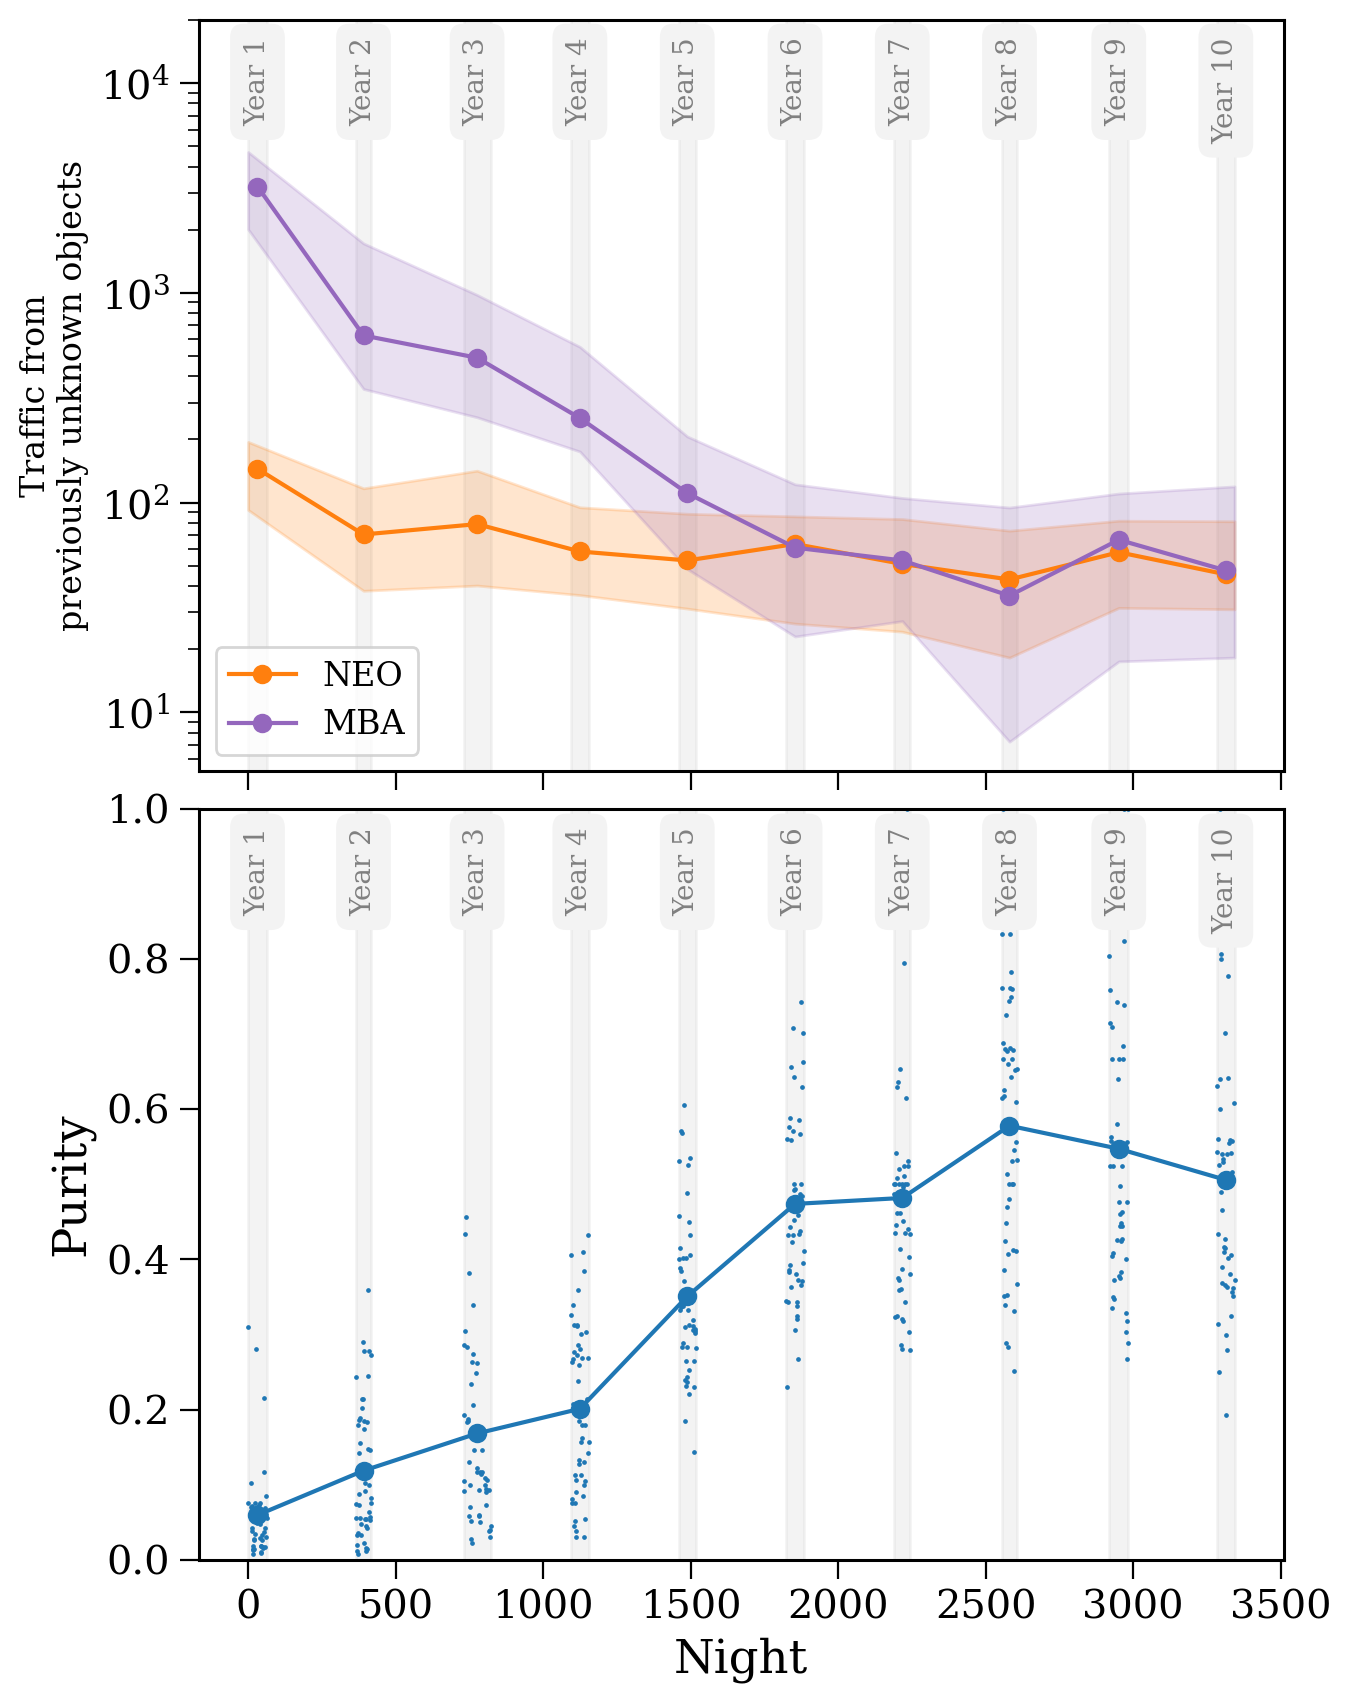

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(7, 10), sharex=True)
fig.subplots_adjust(hspace=0.05)

for traffic, label, colour in zip([neo_traffics, mba_traffics],
                                  ["NEO", "MBA"],
                                  ["tab:orange", "tab:purple"]):
    percs = np.percentile(traffic, [25, 50, 75], axis=1)
    mid_times = years[:, 0] + (years[:, -1] - years[:, 0]) / 2
    axes[0].plot(mid_times, percs[1], marker="o", label=label, color=colour)
#     axes[1].plot(mid_times, np.max(traffic, axis=1), label=label, color=colour, linestyle="--")
    
    # adjust mid times to get area to play nicely
    mid_times[0] = years[0, 0]
    mid_times[-1] = years[-1, -1]
    axes[0].fill_between(mid_times, percs[0], percs[2], alpha=0.2, color=colour)

for ax, y_loc in zip(axes, [1.65e4, 0.975]):
    for i, night_list in enumerate(years, start=1):
        ax.axvspan(night_list[0], night_list[-1], color="lightgrey", alpha=0.25, zorder=-1)
        ax.annotate(f"Year {i}", xy=(night_list[0] + (night_list[-1] - night_list[0]) / 2, y_loc),
                    ha="center", va="top", rotation=90, color="grey",
                    bbox=dict(boxstyle="round", fc="#f3f3f3", ec="none", pad=0.5, zorder=-1))

axes[0].set_ylabel("Traffic from\npreviously unknown objects", fontsize=0.5*fs)
axes[0].set_yscale("log")
axes[0].set_ylim(top=2e4)
axes[0].legend(loc="lower left", fontsize=0.5*fs)

axes[1].scatter(np.ravel(years), np.ravel((neo_traffics / (neo_traffics + mba_traffics))), s=0.5)
axes[1].plot(years[:, 0] + (years[:, -1] - years[:, 0]) / 2,
           np.mean(neo_traffics / (neo_traffics + mba_traffics), axis=1),
           color="tab:blue", marker="o")

axes[1].set_ylabel("Purity", fontsize=0.7 * fs)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Night", fontsize=0.7*fs)

plt.savefig("../paper/figures/digest2_purity_over_lsst.pdf", format="pdf", bbox_inches="tight")

plt.show()

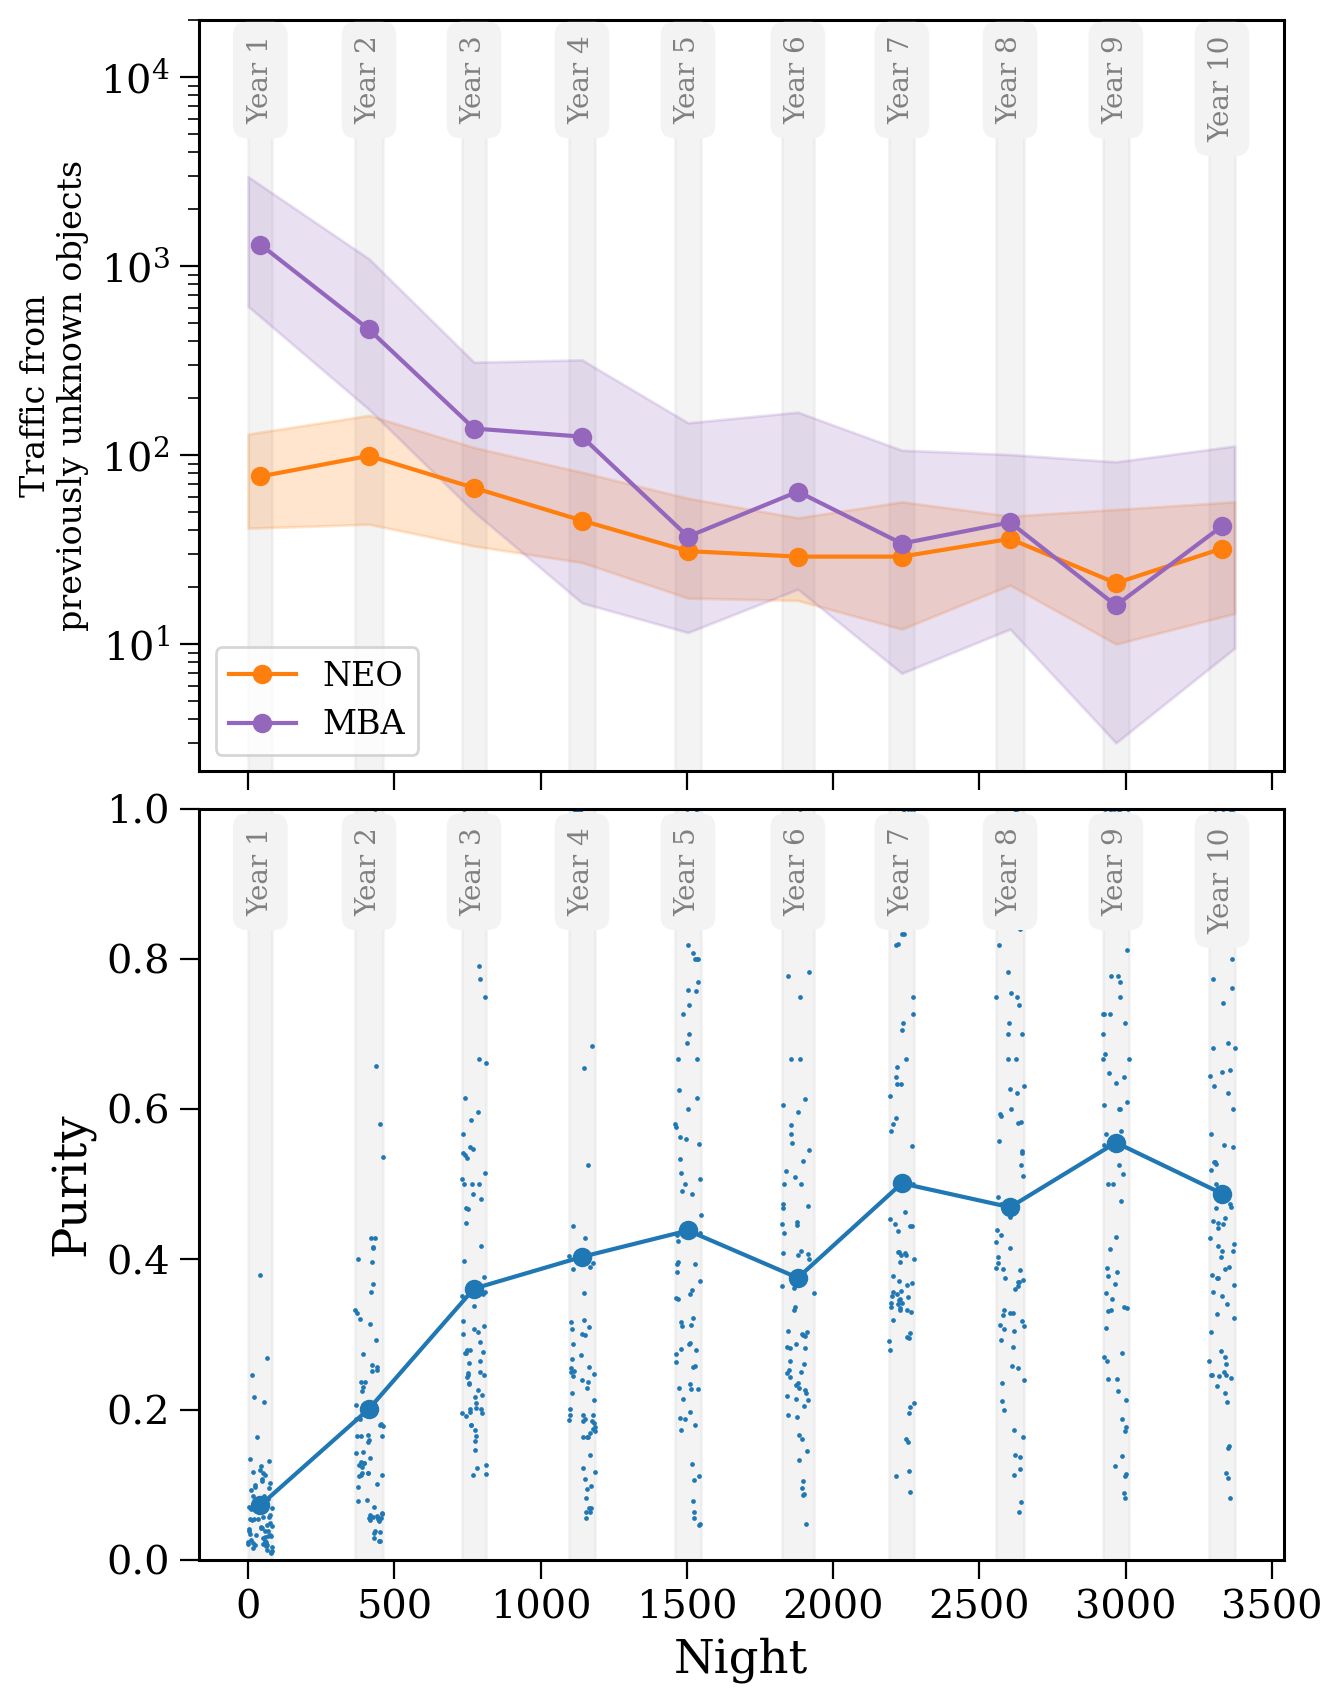

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(7, 10), sharex=True)
fig.subplots_adjust(hspace=0.05)

for traffic, label, colour in zip([neo_traffics, mba_traffics],
                                  ["NEO", "MBA"],
                                  ["tab:orange", "tab:purple"]):
    percs = np.percentile(traffic, [25, 50, 75], axis=1)
    mid_times = years[:, 0] + (years[:, -1] - years[:, 0]) / 2
    axes[0].plot(mid_times, percs[1], marker="o", label=label, color=colour)
    
    # adjust mid times to get area to play nicely
    mid_times[0] = years[0, 0]
    mid_times[-1] = years[-1, -1]
    axes[0].fill_between(mid_times, percs[0], percs[2], alpha=0.2, color=colour)

for ax, y_loc in zip(axes, [1.65e4, 0.975]):
    for i, night_list in enumerate(years, start=1):
        ax.axvspan(night_list[0], night_list[-1], color="lightgrey", alpha=0.25, zorder=-1)
        ax.annotate(f"Year {i}", xy=(night_list[0] + (night_list[-1] - night_list[0]) / 2, y_loc),
                    ha="center", va="top", rotation=90, color="grey",
                    bbox=dict(boxstyle="round", fc="#f3f3f3", ec="none", pad=0.5, zorder=-1))

axes[0].set_ylabel("Traffic from\npreviously unknown objects", fontsize=0.5*fs)
axes[0].set_yscale("log")
axes[0].set_ylim(top=2e4)
axes[0].legend(loc="lower left", fontsize=0.5*fs)

axes[1].scatter(np.ravel(years), np.ravel((neo_traffics / (neo_traffics + mba_traffics))), s=0.5)
axes[1].plot(years[:, 0] + (years[:, -1] - years[:, 0]) / 2,
           np.mean(neo_traffics / (neo_traffics + mba_traffics), axis=1),
           color="tab:blue", marker="o")

axes[1].set_ylabel("Purity", fontsize=0.7 * fs)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Night", fontsize=0.7*fs)

plt.savefig("../paper/figures/digest2_purity_over_lsst.pdf", format="pdf", bbox_inches="tight")

plt.show()